# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import numpy as np
import matplotlib
import pylab as plt
import seaborn as sns

plt.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

matplotlib.rcParams['font.sans-serif'] = "DejaVu Sans"  # silence warning
matplotlib.rcParams['figure.dpi'] = 100  # increase default plot size

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


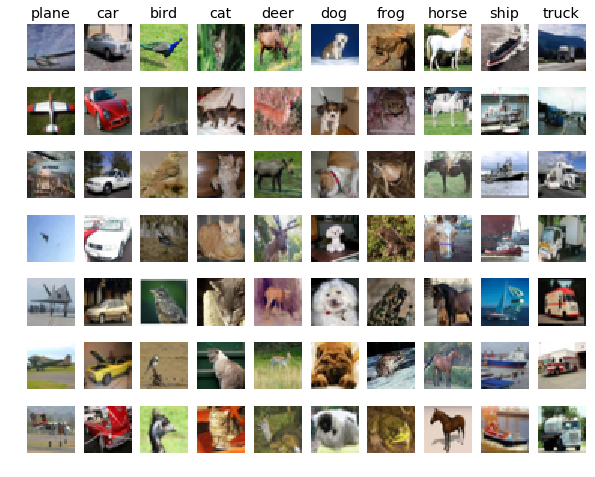

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


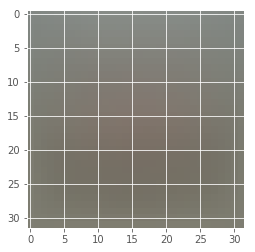

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.083772


## Start of PyTorch Related Code

In [19]:
import torch

dev = torch.device("cuda")          
X_train_g = torch.from_numpy(X_train).to(dev)
X_val_g = torch.from_numpy(X_val).to(dev)
X_test_g = torch.from_numpy(X_test).to(dev)
X_dev_g = torch.from_numpy(X_dev).to(dev)

In [20]:
W_g = (torch.rand((3073, 10)) * 0.0001).to(dev, torch.double)

In [21]:
W = W_g.cpu().numpy()

In [22]:
def svm_loss_torch(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W

    """

    # compute the loss and the gradient
    num_train = X.shape[0]
    W.requires_grad_(True)
    if W.grad is not None:
        W.grad.data.zero_()
    scores_matrix = X.mm(W)
    #correct_classes = [np.arange(y.shape[0]), y]  # shape = (C, N)
    correct_scores = scores_matrix[range(len(y)), y]  # (N, ) -> matrix with the correct scores
    margin_matrix = scores_matrix - correct_scores[:, np.newaxis] + 1  # (N,C)
    margin_matrix[np.arange(num_train), y] = 0
    margin_matrix = torch.clamp(margin_matrix, 0)
    
    loss = margin_matrix.sum()
    loss /= num_train
    
    loss += reg * (W*W).sum()
   
    loss.backward()
    
    dW = W.grad.data
    # dW = dW / num_train

    # loss = loss / num_train
    W.requires_grad_(False)
    return loss, dW

In [23]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_vectorized, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

loss_torch, grad_torch = svm_loss_torch(W_g, X_dev_g, y_dev, 0.000005)
toc = time.time()
print('Vectorized Torch loss: %e computed in %fs' % (loss_torch, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_vectorized - loss_torch.detach().cpu().numpy()))

Vectorized loss: 8.961698e+00 computed in 0.001547s
Vectorized Torch loss: 8.961698e+00 computed in 0.005112s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

Let's compare this with the PyTorch implementation. 


In [24]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearClassifier
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

initializing W
iteration 0 / 1500: loss 801.566784
iteration 100 / 1500: loss 476.924776
iteration 200 / 1500: loss 289.850176
iteration 300 / 1500: loss 176.426381
iteration 400 / 1500: loss 109.447001
iteration 500 / 1500: loss 67.259462
iteration 600 / 1500: loss 42.830694
iteration 700 / 1500: loss 28.056073
iteration 800 / 1500: loss 19.149974
iteration 900 / 1500: loss 13.744731
iteration 1000 / 1500: loss 10.777401
iteration 1100 / 1500: loss 8.594383
iteration 1200 / 1500: loss 7.321532
iteration 1300 / 1500: loss 6.349531
iteration 1400 / 1500: loss 6.140393
That took 102.413998s


## Stochastic Gradient Descent - PyTorch

In [30]:
from cs231n.classifiers import LinearClassifier

class LinearSVMTorch(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """
    
    def __init__(self,):
        # Hack to prevent initialization of W to numpy array
        pass
    
    def update_weights(self, learning_rate, grad):
        self.W.add_(-learning_rate * grad)
        
    def train(self, X, y, learning_rate=1e-7, reg=2.5e4, num_iters=100,
              batch_size=200, verbose=False):
        
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        
        # Mimic weights initialization 
        rand_W =  0.001 * np.random.randn(dim, num_classes)
        self.W = torch.from_numpy(rand_W).to(dev, torch.double)
        return super().train(X, y, learning_rate, reg, num_iters, batch_size, verbose)
        
    def loss(self, X_batch, y_batch, reg):
        return svm_loss_torch(self.W, X_batch, y_batch, reg)


In [31]:
svm = LinearSVMTorch()
tic = time.time()
loss_hist = svm.train(X_train_g, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 783.451690
iteration 100 / 1500: loss 285.678144
iteration 200 / 1500: loss 107.118161
iteration 300 / 1500: loss 42.379170
iteration 400 / 1500: loss 18.818472
iteration 500 / 1500: loss 10.291652
iteration 600 / 1500: loss 7.150235
iteration 700 / 1500: loss 5.650161
iteration 800 / 1500: loss 5.763906
iteration 900 / 1500: loss 6.126926
iteration 1000 / 1500: loss 5.657583
iteration 1100 / 1500: loss 5.452764
iteration 1200 / 1500: loss 6.031734
iteration 1300 / 1500: loss 5.017883
iteration 1400 / 1500: loss 5.533418
That took 2.883235s


If using Pytorch with GPU 3 seconds vs 100 :D nice!

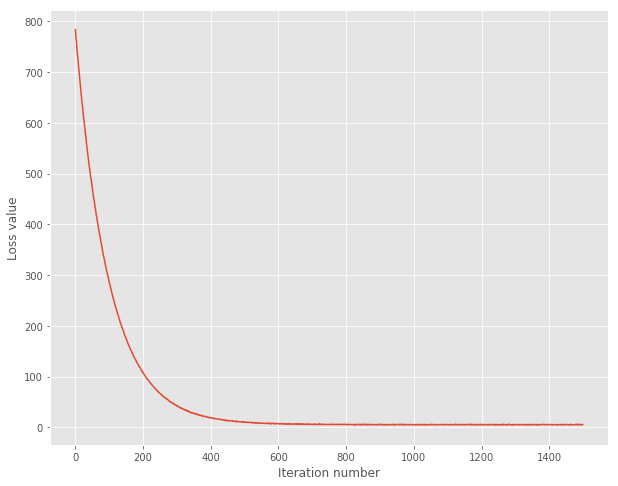

In [32]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [33]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367796
validation accuracy: 0.377000


In [42]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8,0.5e-7, 1e-7, 1e-6]
regularization_strengths = [2.5e4, 5e4, 2.5e5, 5e5, 4e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates:
    for reg in regularization_strengths:

        svm = LinearSVMTorch()
        loss_hist = svm.train(X_train_g, y_train, learning_rate=lr, reg=reg,
                             num_iters=1500, verbose=False)
    
        y_val_pred = svm.predict(X_val)
        
        val_acc = np.mean(y_val == y_val_pred)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
            
        results[(lr, reg)] = (np.mean(y_train == y_train_pred), val_acc)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.367796 val accuracy: 0.256000
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.367796 val accuracy: 0.272000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.367796 val accuracy: 0.310000
lr 1.000000e-08 reg 2.500000e+05 train accuracy: 0.367796 val accuracy: 0.338000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.367796 val accuracy: 0.326000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.367796 val accuracy: 0.393000
lr 5.000000e-08 reg 4.000000e+04 train accuracy: 0.367796 val accuracy: 0.383000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.367796 val accuracy: 0.368000
lr 5.000000e-08 reg 2.500000e+05 train accuracy: 0.367796 val accuracy: 0.338000
lr 5.000000e-08 reg 5.000000e+05 train accuracy: 0.367796 val accuracy: 0.312000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367796 val accuracy: 0.377000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.367796 val accuracy: 0.359000
lr 1.000000e-07 reg 5.000000

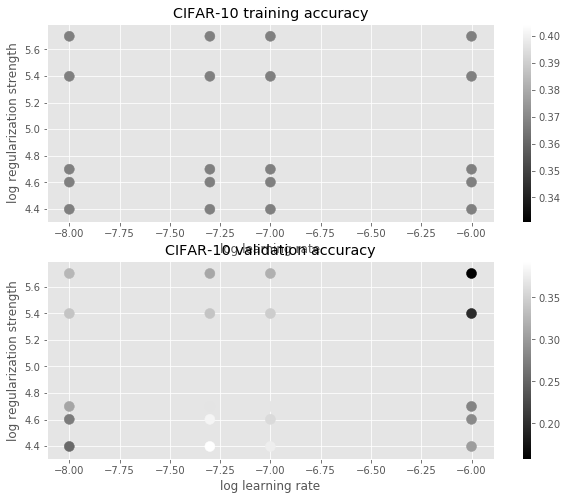

In [43]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [44]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


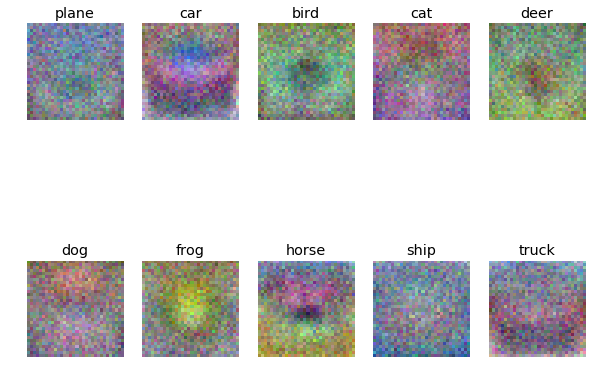

In [47]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W.cpu().numpy()[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 
Contain some of the shapes you would expect on a typical image of that class. E.g. deer is green with a center brown and car is mostly red on the center.